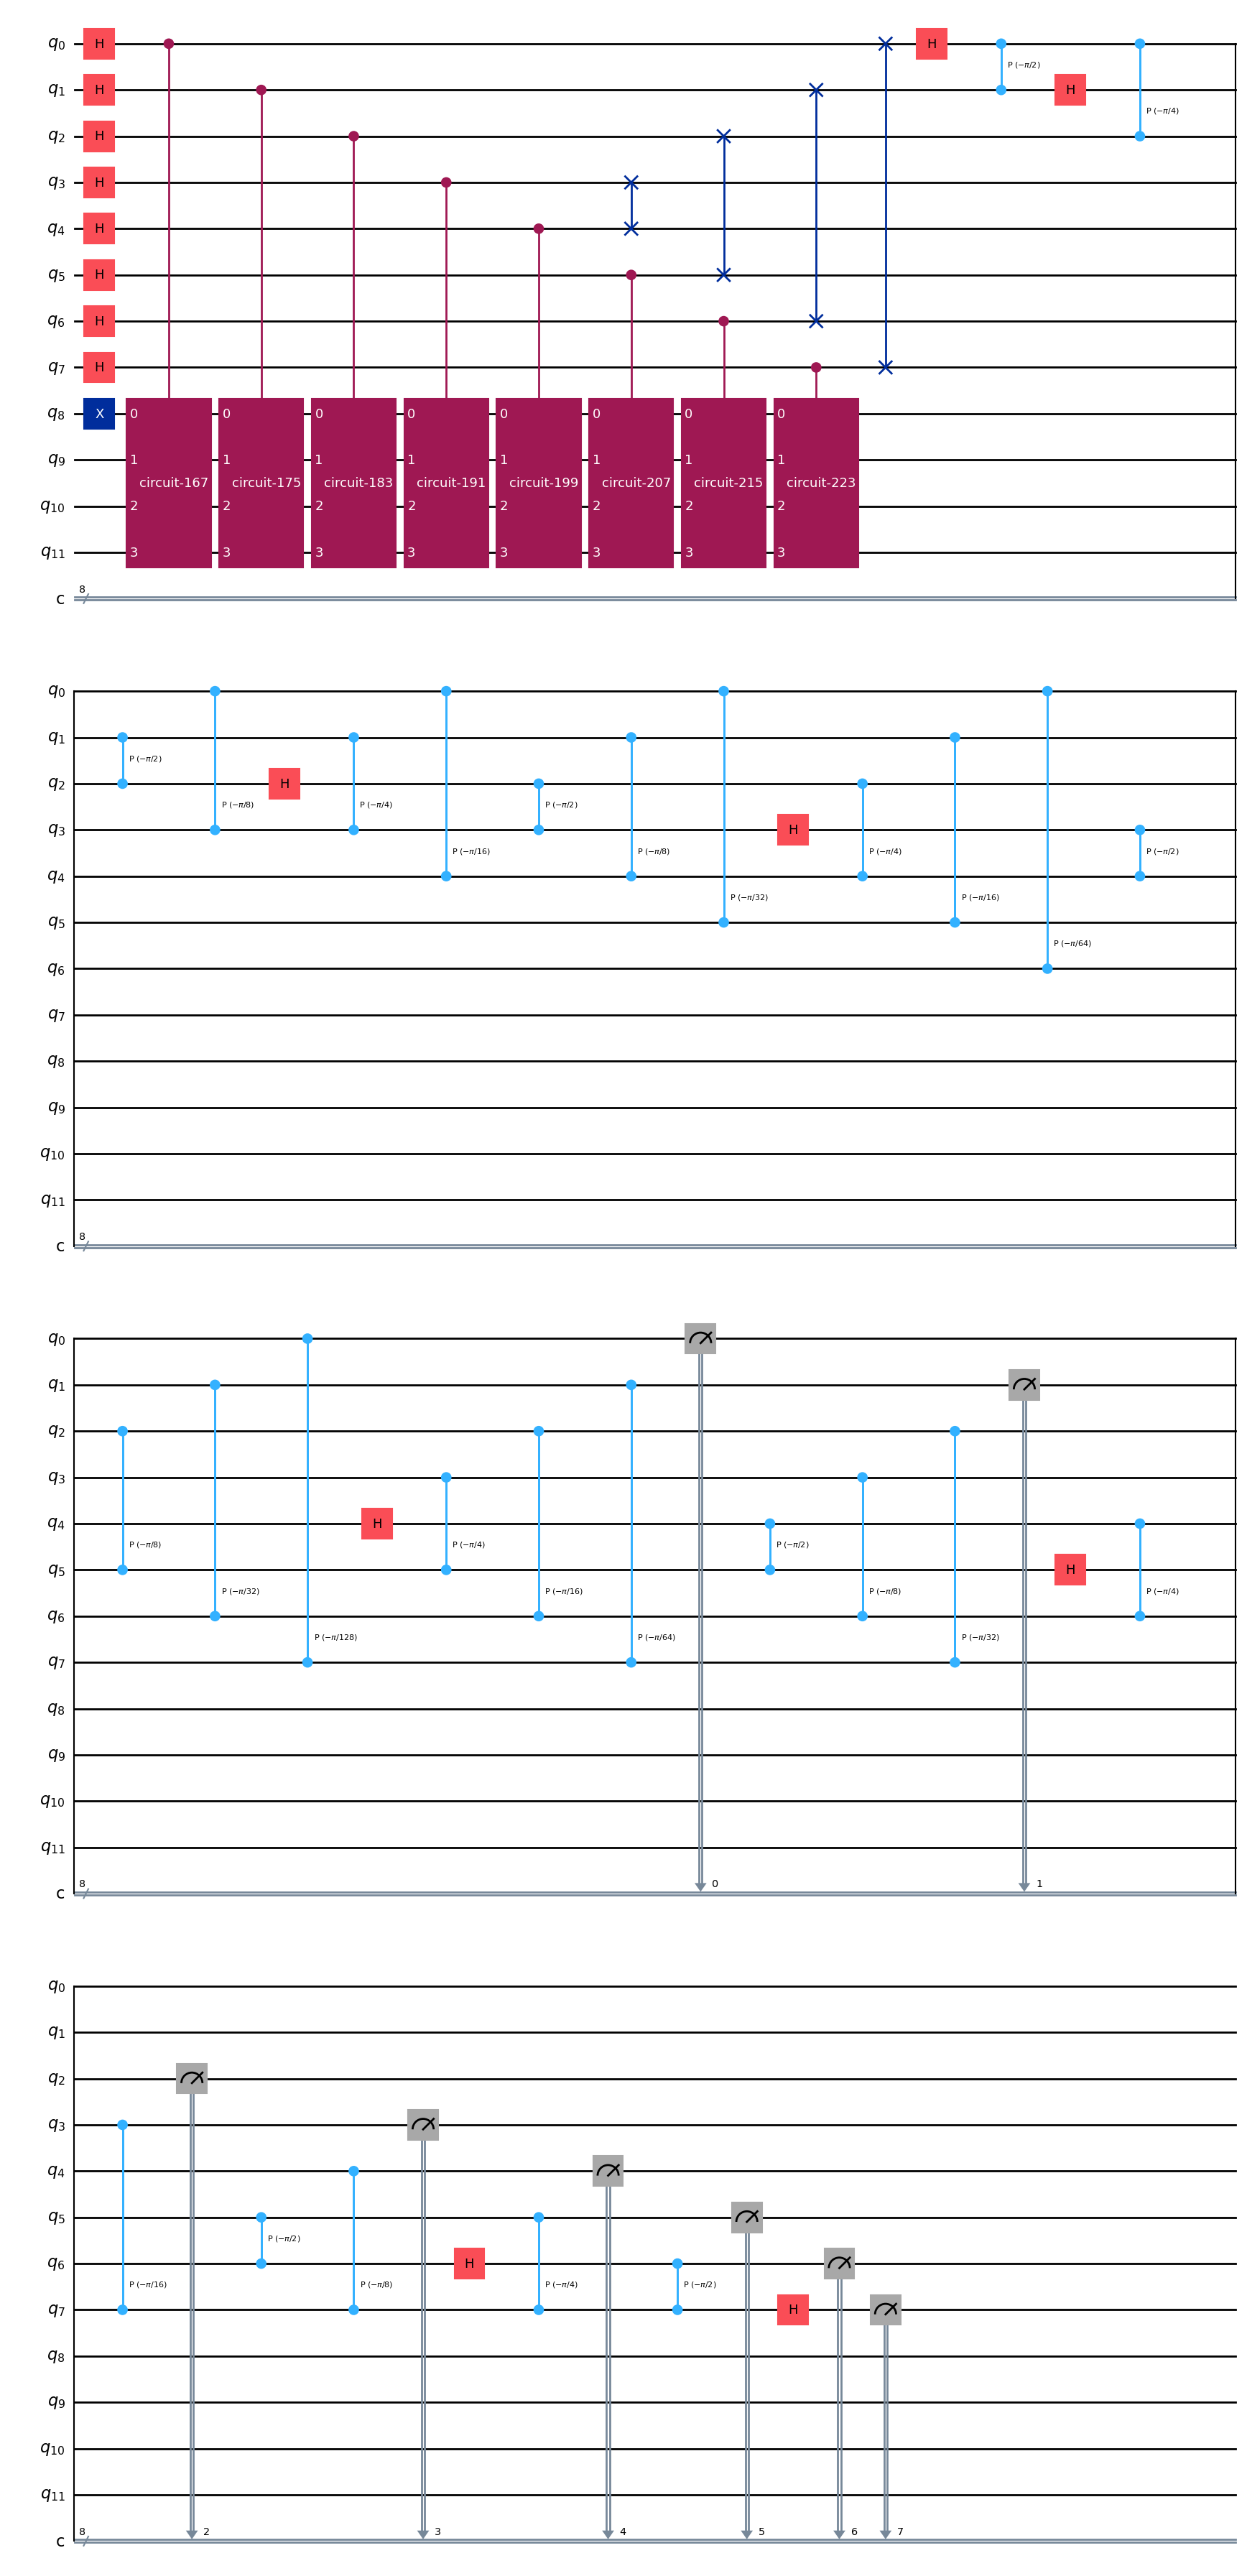

In [1]:
import numpy as np
from numpy import pi
import math
import matplotlib.pyplot as plt
# Qiskitから必要なモジュールをインポート
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram

# cmul_mod15関数（位相推定に使用）
def cmul_mod15(repetitions):
    U = QuantumCircuit(4)
    for i in range(repetitions):
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    U = U.to_gate()
    c_U = U.control(1)
    return c_U

# 逆量子フーリエ変換関数を用意
def qft_rotate_single_inv(circuit, i, n):
    if n == 0:
        return circuit
    for qubit in range(0, i):
        circuit.cp(-pi / 2**(i - qubit), qubit, i)
    circuit.h(i)

def qft_dagger(circuit, n):
    for i in range(math.floor(n / 2)):
        circuit.swap(i, n - (i + 1))
    for i in range(n):
        qft_rotate_single_inv(circuit, i, n)

# アルゴリズムの本体
n_encode = 8  # 求めたい固有値の位相角をエンコードする量子ビット数
n_eigstate = 4  # 固有状態の量子ビット数
qc = QuantumCircuit(n_encode + n_eigstate, n_encode)

# エンコードビットにHadamardゲートを適用
for i in range(n_encode):
    qc.h(i)

# 固有状態の準備
qc.x(n_encode)

# cmul_mod15ゲートを位相推定に使用
repetitions = 1
for count in range(n_encode):
    qc.append(cmul_mod15(repetitions), [count] + [8, 9, 10, 11])
    repetitions *= 2

# 逆量子フーリエ変換
qft_dagger(qc, n_encode)

# 測定
for i in range(n_encode):
    qc.measure(i, i)

qc.draw(output='mpl')



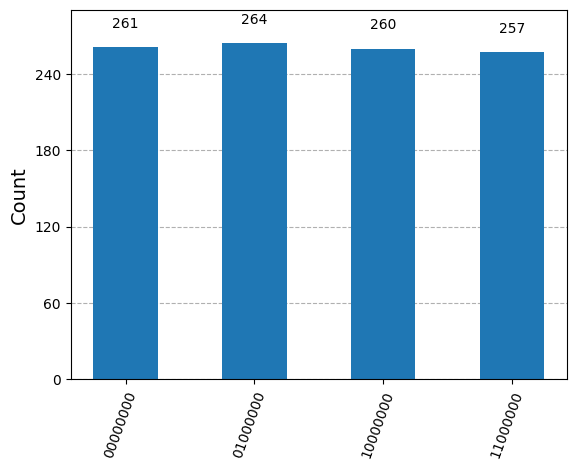

In [2]:
# AerSimulatorを使用して実行
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1042).result()

# 結果を取得して表示
answer = result.get_counts()
plot_histogram(answer)